# Convex Hulls

Elie Fadel  
Anthony Tannoury

## Code Organization

**Note**: The functions in this notebook have been extracted to separate modules for better organization:
- [datasets.py](./datasets.py) - Dataset generation functions
- [geometry.py](./geometry.py) - Geometric utilities  
- [visualization.py](./visualization.py) - Plotting and visualizing
- [benchmarking.py](./benchmarking.py) - Performance testing
- [sweeping_algorithm.py](./sweeping_algorithm.py) - Sweeping algorithm (1st approach)  
- [output_sensitive_algorithm.py](./output_sensitive_algorithm.py) - Output-sensitive algorithm (2nd approach)  
- [windmill_algorithm.py](./windmill_algorithm.py) - Windmill algorithm (3rd approach)

In [ ]:
%load_ext autoreload
%autoreload 2

# 2. Datasets

We're going to start by writing a [`test_dataset`](./visualization.py) function to help us visualize the point sets, where points are represented as tuples `(x, y)`.

In [ ]:
from visualization import test_dataset

## Dataset B

Both coordinates $X$ and $Y$ are random variables where $X \sim \text{Unif}[0, 1]$ and $Y \sim \text{Unif}[0, 1]$.

In [ ]:
from datasets import dataset_B

test_dataset(dataset_B, (10, 1_000, 1_000_000))

## Dataset A

We're going to define a [`rotate`](./datasets.py) method to use for the generation of *dataset A*.  
A natural way to rotate a point around a pivot by an angle $\theta$ would be to use complex numbers.  

$$
z_{\text{rotated}} - z_{\text{pivot}} = e^{i\theta}(z_{\text{point}} - z_{\text{pivot}})
$$

During the generation of *dataset A*, we're going to choose $(0.5, 0.5)$ as our pivot, and the angle $\theta$ is randomly chosen.

In [ ]:
from datasets import dataset_A

test_dataset(dataset_A, (10, 1_000, 1_000_000))

## Dataset C

For the generation of *dataset C*, we will try to implement the method mentioned in the prompt.  
Before we do that, we will need to write a function that checks whether a certain point lies inside of the unit circle.  
This can be easily achieved by checking whether the distance between the point and the center of the circle is less than the radius (1).

However, this generation method for *dataset C* involves a bit of redundancy since on average, $(1-\frac{\pi}{4})n$ of the points would be discarded ($\frac{\pi}{4}$ is the ratio between the area of the circle and its bounding square).  

Let's find another way to generate *dataset C*.  

We're going to generate the polar coordinates of the point.

Let $\Theta$ be the random variable giving the angle of the generated point.  
By rotational symmetry, we deduce that:
$$
\Theta \sim \mathrm{Unif}([0,2\pi])
$$

Let $R$ be the random variable giving the radius in order to obtain a uniform distribution of points in the disk, and let $F$ denote its cumulative distribution function.

If we multiply a radius $x$ by a factor $y$, the area of the disk changes by a factor $y^2$.  
To maintain a uniform distribution of points, we therefore need the probability of being within radius $xy$ to be $y^2$ times the probability of being within radius $x$.  
This leads to the scaling relation $F(xy) = y^2 F(x)$,
which implies that, by taking $y = \frac{1}{x}$, $F(x) \propto x^2 \left(x \in [0; R_{\max}]\right)$.

Since $R \in [0, R_{\max}]$, normalization gives
$$
F(x)=
\begin{cases}
0 & x < 0 \\
\frac{x^2}{R_{\max}^2} & 0 \le x \le R_{\max} \\
1 & x > R_{\max}
\end{cases}
$$

Using the inverse transform method, we can simulate $R$ from a uniform random variable $U \sim \mathrm{Unif}([0,1])$:
$$
R = F^{-1}(U) = R_{\max}\sqrt{U}
$$

Converting the coordinates from polar to cartesian is straightforward: $x = R \cos \Theta$ and $y = R \sin \Theta$.  

This approach leads to a redundancy-free code.

In [ ]:
from datasets import dataset_C

test_dataset(dataset_C, (10, 1_000, 1_000_000))

## Dataset D

For the generation of *dataset D*, we're going to generate the polar coordinates of the points.

Let $\Theta$ be the random variable giving the angle of the generated point.  
By rotational symmetry, we deduce that:
$$
\Theta \sim \mathrm{Unif}([0,2\pi])
$$

Since the points are on the circle, we can deduce that $R = 1$.  

Converting the coordinates from polar to cartesian is straightforward: $x = R \cos \Theta$ and $y = R \sin \Theta$

In [ ]:
from datasets import dataset_D

test_dataset(dataset_D, (10, 1_000, 1_000_000))

# 3. Sweeping

## Sorting the points

The [`sort_points`](./geometry.py) function sorts the points according to their x-coordinate (using *TimSort*) and has $O(n \log n)$ time complexity.

## Clockwise?

The [`is_clockwise`](./geometry.py) function determines if the turn from point $A$ through $B$ to $C$ is clockwise by calculating the 2D cross product of vectors $AB$ and $AC$.

[`is_clockwise`](./geometry.py) returns `False` if $A$, $B$ and $C$ ($x_A < x_B < x_C$) are collinear.  
This choice was made in order to include all three collinear points forming the edge of a hull in the output of the Sweeping algorithm.

Let's test our [`is_clockwise`](./geometry.py) function.

In [ ]:
from geometry import is_clockwise

def test_clockwise():
    assert is_clockwise((0, 0), (1, 0), (1, -1)) == True
    assert is_clockwise((0, 0), (1, 0), (1, 1)) == False
    assert is_clockwise((0, 0), (1, 0), (2, 0)) == False
    assert is_clockwise((0, 0), (1, 1), (2, 2)) == False
    assert is_clockwise((0, 0), (0, 1), (1, 1)) == True
    assert is_clockwise((0, 0), (0, 1), (-1, 1)) == False
    assert is_clockwise((-1, -1), (0, 0), (1, -1)) == True
    assert is_clockwise((-1, -1), (0, 0), (1, 1)) == False
    print("TESTS PASSED")

test_clockwise()

## Computing upper and lower halves of convex hull

The [`compute_upper_hull_1`](./sweeping_algorithm.py) computes the upper half of the convex hull by using the *Sweeping algorithm*.  

Sorting is handled externally in [`compute_convex_hull_1`](./sweeping_algorithm.py) to allow [`computer_upper_hull_1`](./sweeping_algorithm.py) and [`compute_lower_hull_1`](./sweeping_algorithm.py) to share the same pre-sorted input.

To ensure the hull vertices are returned in counterclockwise order, we could utilize a `collections.deque` because it supports $O(1)$ `appendleft` and `popleft` operations, whereas a standard Python list would require $O(n)$ time for insertions at the beginning.  
However, we can achieve the same result by appending to a list and reversing it at the end. Even though that approach would involve another $O(n)$ sweep through the vertices to reverse the list, [`compute_upper_hull_1`](./sweeping_algorithm.py) would still have $O(n)$ time complexity.

[`compute_lower_hull_1`](./sweeping_algorithm.py) is functionally symmetric to [`compute_upper_hull_1`](./sweeping_algorithm.py). We could implement the former but writing a function symmetrical to [`compute_upper_hull_1`](./sweeping_algorithm.py). But we could also simply implement it by negating the y-coordinates of the input, computing the upper hull, and negating the results back.  
Even though negating y-coordinates, computing the upper hull, negating y-coordinates again then reversing the list (to maintain a counterclockwise orientation of the convex hull vertices) would introduce 3 $O(n)$ operations, [`compute_lower_hull_1`](./sweeping_algorithm.py) would still have an $O(n)$ time complexity.

## Testing the *Sweeping algorithm*

### Testing correctness

The [`test_algorithm`](./visualization.py) function verifies that the hull vertices are ordered counterclockwise, that the convex hull has 4 points for *dataset A* and all points for *dataset D*, and then plot the points with their convex hull.

In [ ]:
from visualization import test_algorithm
from sweeping_algorithm import compute_convex_hull_1

test_algorithm(compute_convex_hull_1)

Our *Sweeping algorithm* seems to produce correct results.

## 3.1. Complexity

### Sorting time complexity

The `sorted` function in Python uses an algorithm called *TimSort*. It has $\boxed{O(n \log n)}$ time complexity (where $n$ is the size of the dataset), which is optimal for sorting.

### Maximum time of adding one point

An analysis of the `for` loop in [`compute_upper_half_1`](./sweeping_algorithm.py) reveals that for a point at index $i$ in [`sorted_points`](./geometry.py), the chain may already contain $i$ previous elements. In the worst-case scenario for a single iteration, all elements except the first could be removed, resulting in $i−1$ pop operations. Given that Python’s append and pop operations both exhibit $O(1)$ time complexity, the execution time for processing the point at index $i$ in [`sorted_points`](./geometry.py) is bounded by $\boxed{O(i)}$.

### Bound on the time complexity of the algorithm

Although an individual iteration at index $i$ in [`sorted_points`](./geometry.py) may take $O(i)$ time, the total number of removals across the entire execution cannot exceed the total number of appends.  
Because each point in [`sorted_points`](./geometry.py) is appended to the chain exactly once and subsequently removed at most once, and since Python's `append` and `pop` operations are $O(1)$, the total work is proportional to $n$.  
Thus, the algorithm's time complexity for generating the chain out of already sorted points is $O(n)$.  
Since the sorting at the beginning of [`compute_convex_hull_1`](./sweeping_algorithm.py) has a time complexity of $O(n \log n)$, the total time complextity of the algorithm is $O(n) + O(n \log n) = \boxed{O(n \log n)}$.

### Testing the time complexity of the algorithm

[`get_benchmarks`](./benchmarking.py) is a generic function that benchmarks a given algorithm for different sizes of datasets of chosen types.

`times` in [`get_benchmarks`](./benchmarking.py) stores the time $T$ it takes to compute the convex hull for different dataset types and sizes.  
`ratios` stores the evolution of the ratio $\frac{T}{n}$ for different datasets where $n$ is the size of the dataset.

In [ ]:
from benchmarking import get_benchmarks

We also wrote functions ([`smooth_curve`](./benchmarking.py), [`smooth_benchmark`](./benchmarking.py), [`plot_smooth_benchmarks`](./benchmarking.py)) to smooth those benchmarks since they can have erratic peaks due to overhead.

In [ ]:
from benchmarking import plot_smooth_benchmarks

Let's now benchmark the *Sweeping algorithm* using differents dataset sizes, but using only *dataset B* since the type of the dataset for this algorithm does not matter because we're looping over all of the points regardless of their configuration (see ***[section 5: Comparison](#5-comparison)***).

In [ ]:
dataset_sizes = range(1_000, 100_001, 1_000)
ratios_1, times_1 = get_benchmarks(dataset_sizes, compute_convex_hull_1, [dataset_B])

In [ ]:
plot_smooth_benchmarks(dataset_sizes, times_1, ['Time (ns) (Dataset B)'])

We notice that the profile appears to be linear, which could lead us to believe that our algorithm time complexity analysis was erroneous.  
Let's test whether the profiles are really linear, or whether the slope increments ever so slightly.  
We can test this by observing the ratio evolution calculated earlier.
If the ratio is constant, then the profile is really linear. If it increments logartihmically over time, since $R = \frac{O(n\log n)}{n} = O(\log n$) theoretically, we can deduce that the profile is in fact logarithmic.

In [ ]:
plot_smooth_benchmarks(dataset_sizes, ratios_1, ['Ratio T/n (Dataset B)'], strip=10)

By disregarding the initial data points, which are skewed by fixed overhead costs, the ratio plot exhibits a gradual logarithmically upward trend. This confirms the superlinear $O(n \log n)$ complexity characteristic of the Sweeping algorithm.

# 4. Output-sensitive algorithm

## 4.1. Median

In order to find the median of the x-coordinates, we are going to use an algorithm we studied during the course: the Median of Medians algorithm, which executes in linear time ($O(n)$).  
Since we know that all the points have distinct x-coordinates, we ignored the calculation of the number of pivots and replaced it by 1 where it should have been used.  
Using the [`select`](./geometry.py) function, we wrote [`separator_x`](./geometry.py) which, given a set of points with distinct x-coordinates, returns an $x_m$ such that half the points (rounded down) are strictly to the left of $x=x_m$ and half the points (rounded up) are strictly to the right.

Let's test our functions.

In [ ]:
from random import shuffle
from geometry import select

def test_select():
    # We do not write tests with duplicate values in lists because our 'select' function
    # assumes that all elements of the list are distinct.
    shuffled_range = list(range(1000))
    shuffle(shuffled_range)
    for i in range(1000):
        assert select(shuffled_range, i) == i

    print("TESTS PASSED")

test_select()

In [ ]:
from random import random, randint
from geometry import separator_x

def test_separator_x():
    for _ in range(1000):
        points = [(random(), 0) for _ in range(randint(2, 1000))]
        xm = separator_x(points)
        left = [p for p in points if p[0] < xm]
        assert len(left) == len(points) // 2

    print("TESTS PASSED")

test_separator_x()

## 4.2. Linear programming

Let us prove that the solution is always a line passing through two points of $P$, one with $x < x_m$ and one with $x > x_m$.

Assume that this basis is formed by two points $l_1$ and $l_2$ to the left of $x_m$. Let $r_1$ (resp. $r_2$) be the point that maximizes the slope of the line $(l_1 r_1)$ (resp. $(l_2 r_2)$). This point may not be unique if there exists another point lying on the line $(l_i r_i)$ for $i \in \{1,2\}$, but this happens with probability zero.

By construction of $r_i$, all the other points to the right of $x_m$ lie below the line $(l_i r_i)$.

Moreover, the line $(l_i r_i)$ has a slope smaller than that of $(l_1 l_2)$. Otherwise, $r_1$ or $r_2$ would lie above $(l_1 l_2)$, contradicting the fact that $(l_1 l_2)$ is a basis. Therefore, the lines $(l_1 r_1)$ and $(l_2 r_2)$ intersect the vertical line $x = x_m$ at a point lower than the intersection point between $x = x_m$ and $(l_1 l_2)$.

It remains to show that either $(l_1 r_1)$ or $(l_2 r_2)$ lies above all the other points of $P$, in order to reach a contradiction.

There are two cases: either $l_2$ lies above $(l_1 r_1)$ with $x_{l_2} > x_{l_1}$, or $l_2$ lies below $(l_1 r_1)$ with $x_{l_2} < x_{l_1}$ (the fact that $r_1$ is below $(l_1 l_2)$ gives us the two inequalities on the x-coordinates).

If the first case occurs, then by reasoning similarly on $l_1$, it must be that $l_1$ lies below $(l_2 r_2)$ with $x_{l_1} < x_{l_2}$. In this case, the line $(l_2 r_2)$ lies above all the other points of $P$. Indeed, it suffices to show that it lies above all points to the left of $x_m$ (it is already above all the points to the right of $x_m$ by the choice of $r_2$). Let $L$ be the set of points to the left of $x_m$ that lie above $(l_2 r_2)$, and let $l$ be the point of $P$ that maximizes the slope of the line connecting $l_2$ to a point of $L$. Then it must be that $x_l > x_{l_2}$; otherwise, $l$ would lie above $(l_1 l_2)$ (which can be proven using all the slope inequalities we already have), contradicting the fact that $(l_1 l_2)$ is a basis. Since $l$ lies below $(l_1 l_2)$, the slope of $(l l_2)$ is smaller than the slope of $(l_1 l_2)$, and the line $(l l_2)$ lies above all the points of $P$ (because the slope of $(l l_2)$ is greater than the slope of $(l_2 r_2)$, so $(l l_2)$ lies above all points to the right, and the slope of $(l l_2)$ is smaller than the slope of $(l_1 l_2)$, so $(l l_2)$ lies above all points to the left), while decreasing the y-coordinate of the intersection with $x = x_m$, contradicting the fact that $(l_1 l_2)$ is a basis). Hence, $(l_2 r_2)$ lies above all the other points of $P$ and yields a smaller intersection value at $x = x_m$, contradicting the fact that $(l_1 l_2)$ is a basis.

If the second case occurs, we reason in the same way, and the result follows.

Checking whether $p_k$ is above the basis is straightforward using the [`is_clockwise`](./geometry.py) function already implemented (cf. [`is_above`](./geometry.py)).  
When $p_k$ is above the basis, it acts as a new pivot point.  
We already know that the solution consists of two points: one on the left of $x_m$ and the other on the right. Therefore, if $p_k$ is above the basis and is on the left of $x_m$, we must search for its partner on the right side, and vice versa.    
If $p_k$ is on the left side of $x_m$, in order to minimize the y-value at $x_m$​, we need the line passing through $p_k$ to be as flat as possible while still clearing every point on the right. This is achieved by searching for the partner on the right that yields the maximum slope, as any line with a smaller slope would leave that partner point above the line.  
Conversely, if $p_k$ is on the right, we seek the partner on the left that yields the minimum slope to ensure the line clears all points while remaining as low as possible at the $x_m$ crossing.

Let's test the [`find_upper_basis`](./geometry.py) function.

In [ ]:
from geometry import find_upper_basis
import matplotlib.pyplot as plt

def test_find_upper_basis():
    test_cases = []
    for i in range(4):
        points = [(0, random()), (1, random())] + [(random(), random()) for _ in range(randint(0, 50))]
        test_cases.append((random(), points, f"Test case {i+1}"))

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()
    
    for idx, (x_m, points, title) in enumerate(test_cases):
        ax = axes[idx]
        basis = find_upper_basis(x_m, points)
        
        x_coords, y_coords = zip(*points)
        ax.scatter(x_coords, y_coords, color='blue', s=5, label='Points', zorder=3)
        
        ax.axvline(x_m, color='gray', linestyle='--', linewidth=1.5, label=f'$x_m$ = {x_m:.2f}', zorder=1)
        
        basis_x, basis_y = zip(*basis)

        ax.plot(basis_x, basis_y, color='red', linewidth=1, label='Basis', zorder=4)
        ax.scatter(basis_x, basis_y, color='green', s=20, zorder=5)

        x1, y1 = basis[0]
        x2, y2 = basis[1]
        dx, dy = x2 - x1, y2 - y1
        seg_len = (dx**2 + dy**2) ** 0.5
        if seg_len > 1e-12:
            x_range = max(x_coords) - min(x_coords)
            y_range = max(y_coords) - min(y_coords)
            ext = max(x_range, y_range) + 1e-6
            t = ext / seg_len
            ext_p1 = (x1 - dx * t, y1 - dy * t)
            ext_p2 = (x2 + dx * t, y2 + dy * t)
            ax.plot([ext_p1[0], ext_p2[0]], [ext_p1[1], ext_p2[1]],
                    color='red', linestyle='--', linewidth=1, alpha=0.7, zorder=2)
        
        ax.set_aspect('equal')
        ax.set_title(title)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

test_find_upper_basis()

## 4.3. Main algorithm

We can use [`find_upper_basis`](./geometry.py) in our [`compute_upper_hull_2`](./output_sensitive_algorithm.py) since it requires $x_m$ to be distinct of all the x-coordinates in `points` and we know [`separator_x`](./geometry.py) returns a separating x-coordinate that is distinct from all the x-coordinates in `points`.

In order to write [`compute_lower_hull_2`](./output_sensitive_algorithm.py), we can negate the y-coordinates of the points, compute the upper hull using the new algorithm, and negate the y-coordinates of the computed upper hull vertices.  
Since these are $O(n)$ operations and the algorithm theoretically executes in $O(n \log h)$ time, then they do not affect the algorithm's asymptotic performance.

We then combined the two functions to write [`compute_convex_hull_2`](./output_sensitive_algorithm.py).

## Testing the *Output-sensitive algorithm*

In [ ]:
from output_sensitive_algorithm import compute_convex_hull_2

test_algorithm(compute_convex_hull_2)

## Benchmarking the *Output-sensitive algorithm*

Let's now benchmark the *Output-sensitive algorithm* using differents dataset types and sizes, and check whether they confirm the $O(n \log h)$ theoretical time complexity.

> The results of these benchmarks will be interpreted in [***section 5: Complexity***](#the-influence-of-point-distribution-on-hull-size).

In [ ]:
dataset_sizes = range(1_000, 100_001, 1_000)
ratios_2, times_2 = get_benchmarks(dataset_sizes, compute_convex_hull_2, [dataset_A, dataset_B, dataset_C, dataset_D])

In [ ]:
plot_smooth_benchmarks(
    dataset_sizes,
    times_2,
    ['Time (ns) (Dataset A)', 'Time (ns) (Dataset B)', 'Time (ns) (Dataset C)', 'Time (ns) (Dataset D)']
)

In [ ]:
plot_smooth_benchmarks(
    dataset_sizes,
    ratios_2,
    ['Ratio T/n (Dataset A)', 'Ratio T/n (Dataset B)', 'Ratio T/n (Dataset C)', 'Ratio T/n (Dataset D)'],
    strip=10
)

# 5. Comparison

## Correctness and output comparison

Both algorithms produce the same result because the convex hull of a set of points is unique. The only possible ambiguity concerns points lying on the boundary of the hull (collinear points on an edge).  
The *Sweeping algorithm* includes all of the collinear points on an edge of the hull. However, because of the random aspect of the *Output-sensitive algorithm*, the point between the two others might be included or not.

## Performance and dependence on dataset type

The *Sweeping algorithm* has a time complexity of $O(n \log n)$ and does not depend on the geometric structure of the dataset: it processes all points in the same way regardless of whether they form a square, a circle, or a random cloud.  
In contrast, the *Output-sensitive algorithm* has complexity $O(n \log h)$, where $h$ is the number of points on the convex hull. Since $h$ strongly depends on the dataset shape, this algorithm is sensitive to the type of dataset: for circular datasets such as *C* or *D*, $h$ is much larger than for datasets like *A* or *B*, since the convex hull of points in a circular formation is much larger than the one for points in a square formation, leading to higher running times. Nevertheless, because $h \leq n$, the *Output-sensitive algorithm* remains asymptotically better than or equal to the first one, and is therefore more efficient in general.

## The influence of point distribution on hull size

Let's consider the expected number of vertices $\mathbb{E}[h]$ on the convex hull, which varies significantly depending on the geometry of the input distribution.  

For *dataset A*, the number of hull vertices $h$ is deterministically fixed at 4, as the inclusion of the square's corners ensures they always constitute the complete set of extreme points. Therefore, we can expect a time complexity for the *Output-sensitive algorithm* of $O(n \log 4) = O(n)$.  

According to the Rényi-Sulanke theorems <a id="ref1"></a> [[1]](#references), as summarized by Har-Peled <a id="ref2"></a> [[2]](#references), for a uniform distribution within the unit square (which corresponds to *dataset B*), the expected number of vertices on the hull $\mathbb{E}[h]$ is $O(\log n)$ *(lemma 2.4)* [[2]](#references), growing extremely slowly as points cluster primarily near the corners. This results in an $O(n \log(\log n))$ expected time complexity if we use *dataset B*.  

In contrast, for a uniform distribution within a disk (which corresponds to *dataset C*), the curvature of the boundary allows more points to remain on the hull, resulting in an expected size $\mathbb{E}[h]$ of $O(n^{1/3})$ *(theorem 2.3)* [[2]](#references). The expected time complexity becomes $O\left(n \log(n^{1/3})\right) = O(n \log n)$.  

Finally, for *dataset D*, it is clear that $h=n$, and we can expect a time complexity of $O(n \log n)$.

By considering $R = \frac{T}{n}$ for each of the datasets, we can see that $R_A = O(1)$, $R_B = O(\log (\log n))$ and $R_C = R_D = O(\log n)$.  
By interpreting the profiles and the amplitude of the benchmarks above, we can clearly see that they provide strong empirical support for the hypothesis.

## Performance comparison

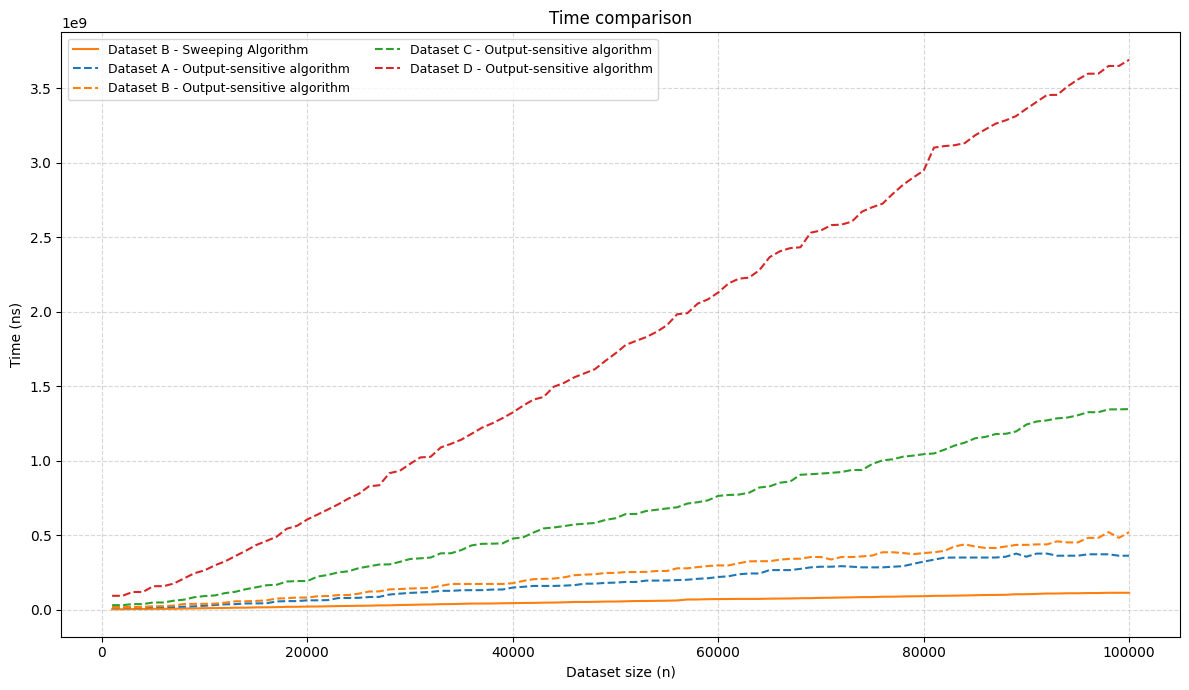

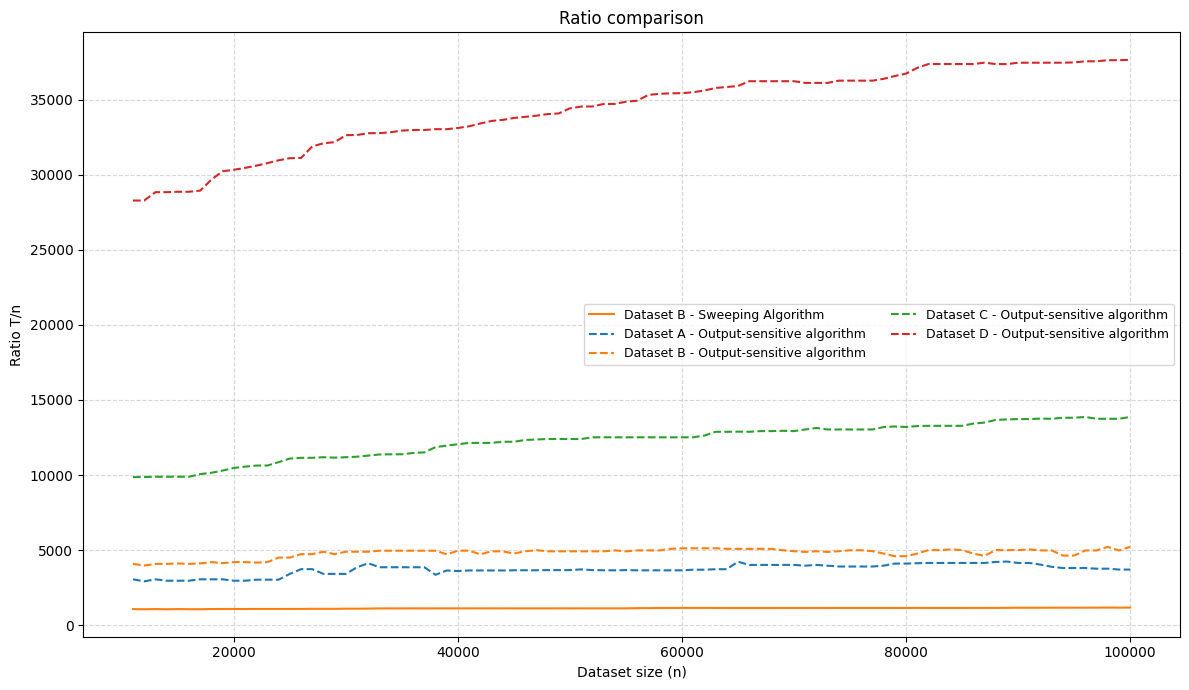

In [43]:
from visualization import plot_overlay

plot_overlay(
    dataset_sizes,
    times_1,
    times_2,
    ['Dataset B'],
    ['Dataset A', 'Dataset B', 'Dataset C', 'Dataset D'],
    'Time (ns)',
    'Time comparison'
)

plot_overlay(
    dataset_sizes,
    ratios_1,
    ratios_2,
    ['Dataset B'],
    ['Dataset A', 'Dataset B', 'Dataset C', 'Dataset D'],
    'Ratio T/n',
    'Ratio comparison',
    strip=10
)

The observed performance results, where the *sweeping algorithm* ($O(n \log n)$) consistently outperforms the *output-sensitive* algorithm ($O(n\log h)$), are a classic demonstration of the distinction between asymptotic complexity and actual running time.  

While Big-O notation describes the rate of growth as $n \rightarrow +\infty$, it intentionally suppresses constant factors and lower-order terms. For example: $O\left(10^5 n \times (\log n)^{10})\right) = O(n)$. The actual running time is better modeled as $T(n)=k\times f(n)$, where $k$ represents the constant overhead of operations (so we do not fully ignore the constants in our Big-O notation).  

The *sweeping algorithm* typically benefits from a very small constant factor $k_\text{sweep}$ because it relies on highly optimized sorting routines and because it is simple and efficient.

In contrast, *output-sensitive* algorithms often require complex data structures, recursion, or intricate pruning logic to achieve their theoretical bounds. These mechanisms introduce a substantial constant factor $k_\text{output}$, significantly increasing the cost per operation.  

This is clearly visible in *dataset A*: although $h=4$ reduces the theoretical complexity of $O(n \log h)$ to $O(n)$, the high operational overhead shifts the curve upward. While the slope of the *Dataset A - Output-sensitive algorithm* curve in the first graph is indeed linear, its vertical position remains higher than the *sweeping algorithm* because $k_\text{output} \gg k_\text{sweep}$.  

The *output-sensitive* algorithm would theoretically begin to "win" only at a much larger $n$, where the multiplicative impact of the $\log n$ term in the *sweeping algorithm* finally exceeds the ratio of the constant factors $\frac{k_\text{output}}{k_\text{sweep}}$.  
For the dataset sizes tested here, the raw efficiency of the simpler sweeping approach dominates the theoretical advantage of output sensitivity.

# 6. Another algorithm: the *Windmill process*

Let's take a look at **Problem 2** of the *2011 International Mathematical Olympiad (IMO)* <a id="ref3"></a> [[3]](#references):  

**Problem 2.** Let $\mathcal{S}$ be a finite set of at least two points in the plane. Assume that no three points of $\mathcal{S}$ are collinear. A windmill is a process that starts with a line $\ell$ going through a single point $P \in \mathcal{S}$. The line rotates clockwise about the *pivot* $P$ until the first time that the line meets some other point belonging to $\mathcal{S}$. This point, $Q$, takes over as the new pivot, and the line now rotates clockwise about $Q$, until it next meets a point of $\mathcal{S}$. This process continues indefinitely.  
Show that we can choose a point $P$ in $\mathcal{S}$ and a line $\ell$ such that the resulting windmill uses each point of $\mathcal{S}$ as a pivot infinitely many times.

Our exploration of the *2011 IMO Problem 2* was deeply influenced by *Grant Sanderson*’s visual breakdown on the *3Blue1Brown* YouTube channel <a id="ref4"></a> [[4]](#references), which illustrated the *Windmill process* as a dynamic rotation around a point set. By analyzing the mechanics of how the pivot point transitions from one star to another, we began to formulate a systematic way to traverse the exterior of a point cloud and construct the convex hull.  
It was during this process of formalizing our approach that we realized our logic mirrored the *Gift-Wrapping algorithm* (also known as the *Jarvis march*).

## How it works

To construct the convex hull, we begin by identifying the leftmost point in the set: this process requires a single linear scan of $O(n)$ time. This point is guaranteed to be a vertex of the hull. We then initialize the windmill by drawing a vertical line through this pivot and begin rotating it counterclockwise. As the line sweeps through the plane, the first point it encounters becomes the next vertex of the hull. If three points happen to be collinear (which occurs with probability 0 using our dataset generation functions), we keep the farthest one from the pivot. This new point then acts as the pivot for the subsequent rotation. By repeating this process, the line "wraps" around the point cloud, effectively tracing the perimeter.  

We specifically chose a counterclockwise rotation to ensure that the resulting sequence of vertices matches the required output order. The process concludes once the rotating line returns to the original leftmost point, completing the boundary.  

The core of the loop logic relies on identifying that "first point encountered" without actually simulating every degree of a rotation. For each new pivot, the algorithm performs a nested pass through all $n$ points to find the best candidate for the next vertex. It treats the current candidate as a tentative boundary and compares it against every other point $p$ using the [`is_clockwise`](./geometry.py) orientation test. If the algorithm finds a point $p$ that makes a clockwise turn relative to the current pivot-candidate segment, it means $p$ is "more to the right" and would be hit by the rotating line first. The algorithm then updates the candidate to $p$ and continues the search. This ensures that when the inner loop finishes, the chosen point is the most extreme outlier, keeping all other points in the set strictly to the left of the new hull edge.

## Complexity

To demonstrate the $O(nh)$ time complexity of [`compute_convex_hull_3`](./windmill_algorithm.py), we look at the structure of the nested operations. The algorithm consists of an outer loop that runs exactly $h$ times, where $h$ is the number of vertices that ultimately make up the convex hull. For every one of these $h$ vertices, the algorithm must trigger an inner loop that performs a linear scan across all $n$ points in the dataset to determine which one is the most clockwise candidate. Since each of these $n$ comparisons involves a constant-time orientation check ($O(1)$), the cost per hull point is $O(n)$. Multiplying the number of points found ($h$) by the work done to find each one ($n$) yields a total running time of $O(nh)$.

## *Windmill process* visualization

We wrote a [`visualize_windmill_steps`](./visualization.py) in order to better understand how this algorithm works.

In [ ]:
from visualization import visualize_windmill_steps

B = dataset_B(100)
visualize_windmill_steps(B)

## Testing the *Windmill process* (approach no.1)

In [ ]:
from windmill_algorithm import compute_convex_hull_3

test_algorithm(compute_convex_hull_3)

## Benchmarking the *Windmill process* (approach no.1)

In [ ]:
dataset_sizes = range(1_000, 100_001, 1_000)
ratios_3, times_3 = get_benchmarks(dataset_sizes, compute_convex_hull_3, [dataset_A, dataset_B, dataset_C, dataset_D])

In [ ]:
plot_smooth_benchmarks(
    dataset_sizes, 
    times_3,
    ['Time (ns) (Dataset A)', 'Time (ns) (Dataset B)', 'Time (ns) (Dataset C)', 'Time (ns) (Dataset D)']
)

In [ ]:
plot_smooth_benchmarks(
    dataset_sizes,
    ratios_3,
    ['Ratio T/n (Dataset A)', 'Ratio T/n (Dataset B)', 'Ratio T/n (Dataset C)', 'Ratio T/n (Dataset D)'],
    strip=10
)

As discussed in ***[section 5: Comparison](#the-influence-of-point-distribution-on-hull-size)***, by replacing $h$ by its expected value for each dataset type (4 for *A*, $\log n$ for *B*, $n^{1/3}$ for *C* and $n$ for *D*), the graph profiles we observe confirm the $O(nh)$ time complexity for the *Windmill process*.

## Alternative angle-based approach

While [`compute_convex_hull_3`](./windmill_algorithm.py) uses the [`is_clockwise`](./geometry.py) orientation test to find the next hull vertex, [`compute_convex_hull_4`](./windmill_algorithm.py) adopts an angle-based strategy. Instead of comparing orientations, it maintains a "windmill vector" that tracks the direction of the previous edge and finds the point that requires the smallest counterclockwise rotation from this vector. The [`get_rotation_angle`](./geometry.py) function computes the signed angle between two vectors using `atan2`, which naturally handles all quadrants and edge cases. This approach is conceptually closer to the geometric interpretation of the *Windmill process*, as it directly measures rotational progression around each pivot.  
Both algorithms achieve the same $O(nh)$ time complexity and produce identical results, but [`compute_convex_hull_4`](./windmill_algorithm.py) provides a more explicit representation of the rotation mechanics at play.

## Testing the *Windmill process* (approach no.2)

In [ ]:
from windmill_algorithm import compute_convex_hull_4

test_algorithm(compute_convex_hull_4)

# References

[[1]](#ref1) Rényi, A., Sulanke, R. über die konvexe Hülle von n zufällig gewählten Punkten. Z. Wahrscheinlichkeitstheorie verw Gebiete 2, 75–84 (1963). [https://doi.org/10.1007/BF00535300](https://doi.org/10.1007/BF00535300)

[[2]](#ref2) Har-Peled, S. (2011). On the Expected Complexity of Random Convex Hulls, [https://arxiv.org/pdf/1111.5340](https://arxiv.org/pdf/1111.5340)

[[3]](#ref3) Problem 2. 52nd International Mathematical Olympiad, Amsterdam, 2011, International Mathematical Olympiad, [www.imo-official.org/problems/imo2011_probs.pdf](https://pub.math.leidenuniv.nl/~smitbde/pop/2011_imo_final6.pdf)

[[4]](#ref4) The Unexpectedly Hard Windmill Question (2011 IMO, Q2). YouTube, uploaded by 3Blue1Brown, 4 Aug. 2019, [https://youtu.be/M64HUIJFTZM](https://youtu.be/M64HUIJFTZM)